# Insights and Recommendations


Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.dates as mdates
from collections import Counter
import yake


Load your preprocessed dataset

In [2]:
df = pd.read_csv("/Users/elbethelzewdie/Documents/customers-satisfaction-week2/customers-satisfaction-week2/notebooks/data/processed/cleaned_review_sentiment.csv", parse_dates=['review_date'])
df = df.drop(columns=['app_id'])

## 1. Rating Distribution per Bank


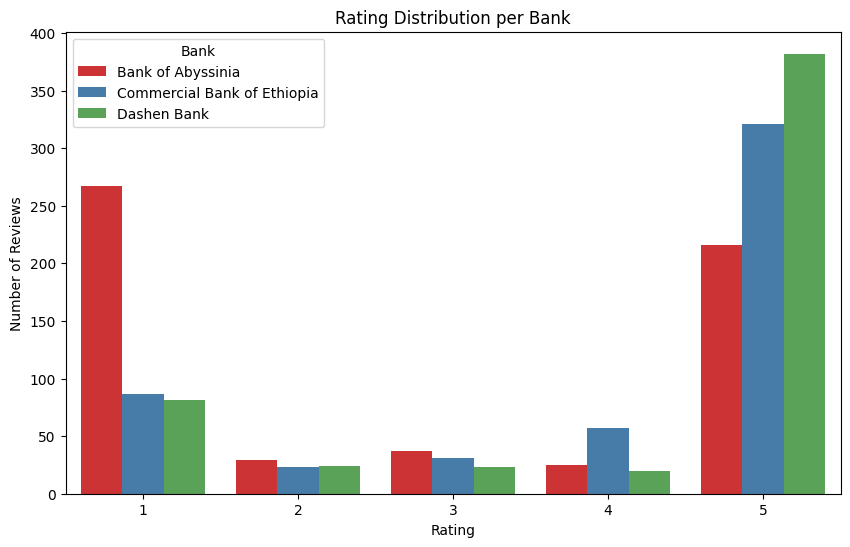

In [3]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='rating', hue='bank_name', palette='Set1')
plt.title('Rating Distribution per Bank')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.legend(title='Bank')
plt.show()

## 2. Word Clouds for Positive and Negative Reviews

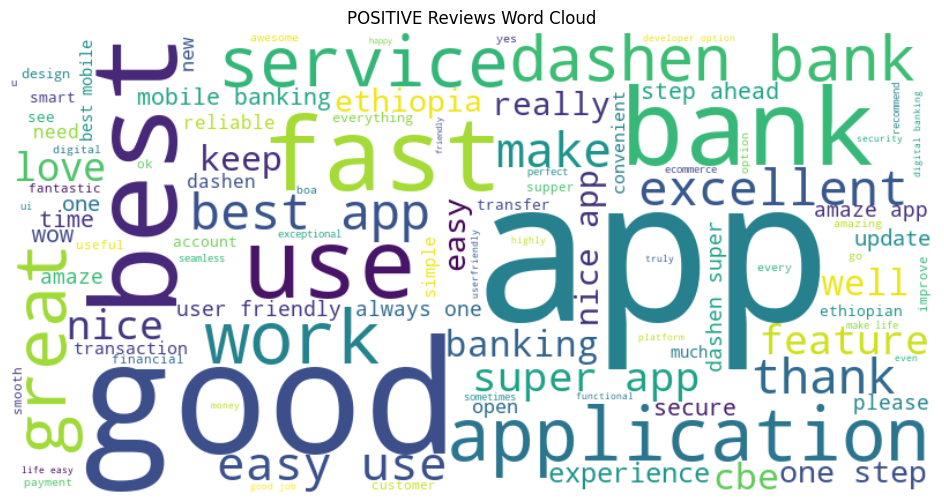

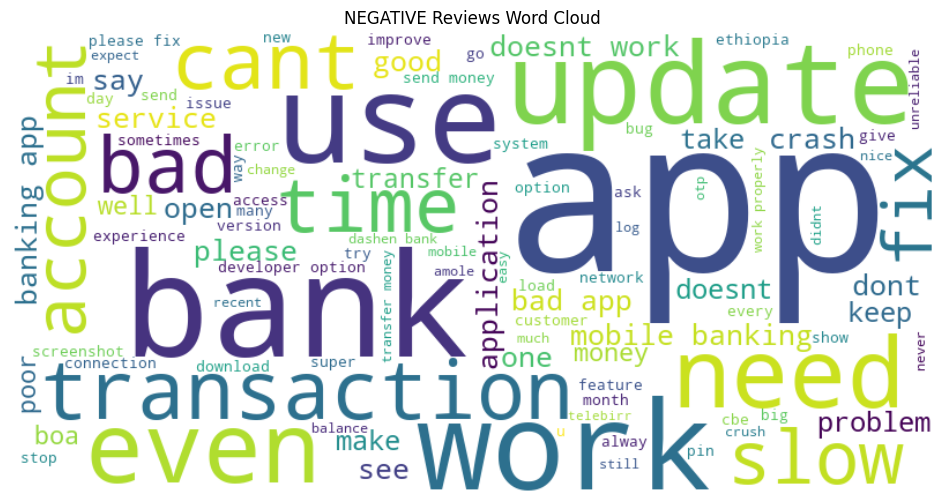

In [4]:
for sentiment in ['POSITIVE', 'NEGATIVE']:
    text = " ".join(df[df['sentiment_label'] == sentiment]['review_text'].dropna())
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment} Reviews Word Cloud')
    plt.show()

## 3. One month sentiment trend plots per bank

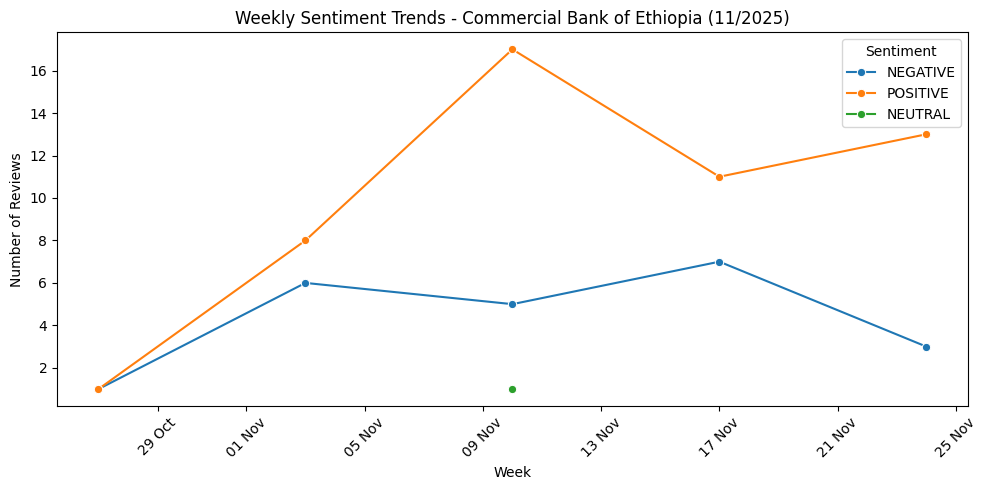

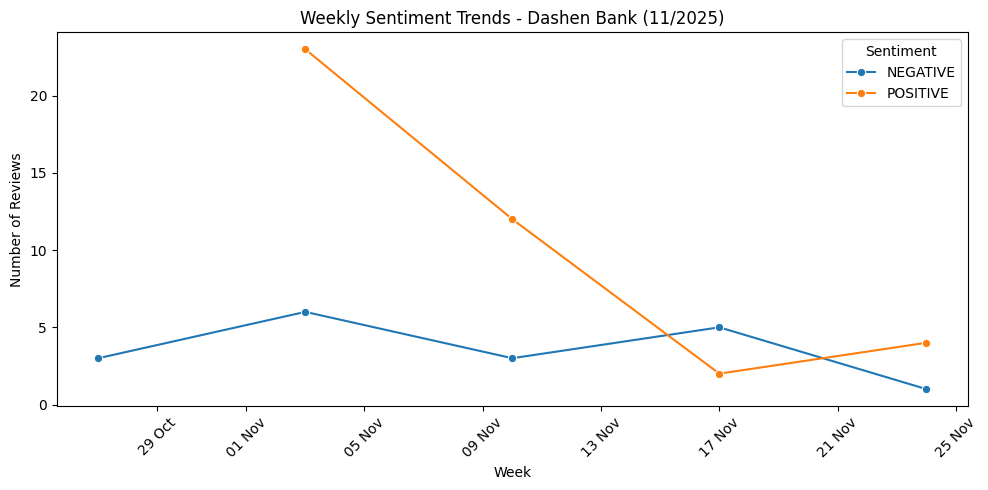

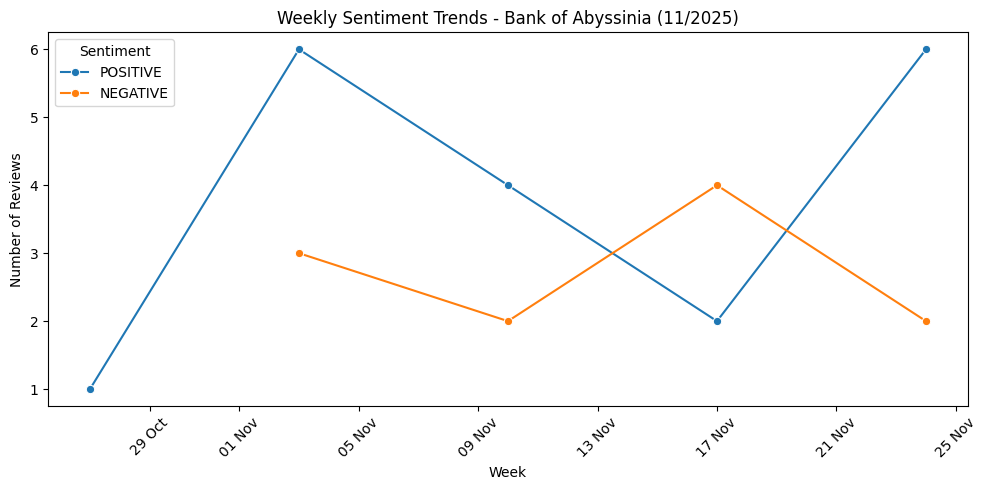

In [5]:
# --- 1. Select latest month dynamically ---
latest_month = df['review_date'].max().month
latest_year = df['review_date'].max().year

# Filter dataframe and make a copy to avoid warnings
df_month = df[(df['review_date'].dt.year == latest_year) &
              (df['review_date'].dt.month == latest_month)].copy()

# --- 2. Aggregate by week ---
df_month['week'] = df_month['review_date'].dt.to_period('W').apply(lambda r: r.start_time)

# --- 3. Plot weekly sentiment trends for each bank ---
banks = df_month['bank_name'].unique()

for bank in banks:
    df_bank = df_month[df_month['bank_name'] == bank]
    weekly_counts = df_bank.groupby(['week', 'sentiment_label']).size().reset_index(name='count')
    
    plt.figure(figsize=(10,5))
    sns.lineplot(data=weekly_counts, x='week', y='count', hue='sentiment_label', marker='o')
    
    plt.title(f'Weekly Sentiment Trends - {bank} ({latest_month}/{latest_year})')
    plt.xlabel('Week')
    plt.ylabel('Number of Reviews')
    
    # Show all weeks in the month, formatted nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.xticks(rotation=45)
    
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()


### monthly sentiment trend plots per bank

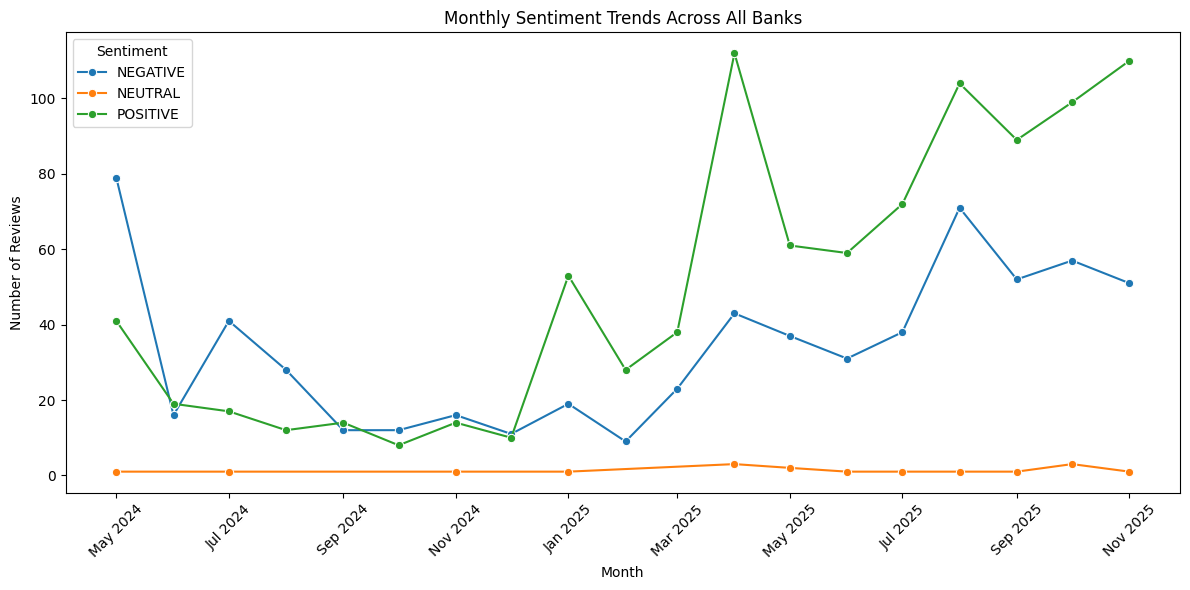

In [6]:
df['month'] = df['review_date'].dt.to_period('M').apply(lambda r: r.start_time)
monthly_counts = df.groupby(['month', 'sentiment_label']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_counts, x='month', y='count', hue='sentiment_label', marker='o')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.title('Monthly Sentiment Trends Across All Banks')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## 4. Sentiment vs Rating Heatmap

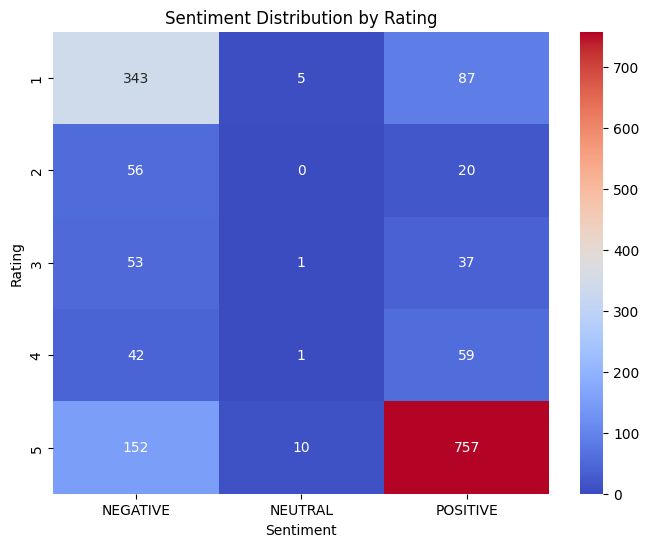

In [7]:
heatmap_data = df.groupby(['bank_name', 'rating', 'sentiment_label']).size().reset_index(name='count')

pivot = heatmap_data.pivot_table(index='rating', columns='sentiment_label', values='count', aggfunc='sum').fillna(0)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt='g', cmap='coolwarm')
plt.title('Sentiment Distribution by Rating')
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.show()

In [8]:
# Initialize YAKE
kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=20)

def extract_keyphrases(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    keywords = kw_extractor.extract_keywords(text)
    return [kw for kw, score in keywords]

def get_keyphrases(df):
    all_phrases = []
    for review in df["review_text"]:
        phrases = extract_keyphrases(review)
        all_phrases.extend(phrases)
    return pd.Series(all_phrases).value_counts().head(15)

drivers = {}
pain_points = {}

for bank in df["bank_name"].unique():
    bank_df = df[df["bank_name"] == bank]

    # Positive = drivers
    pos_df = bank_df[bank_df["sentiment_label"] == "POSITIVE"]
    drivers[bank] = get_keyphrases(pos_df)

    # Negative = pain points
    neg_df = bank_df[bank_df["sentiment_label"] == "NEGATIVE"]
    pain_points[bank] = get_keyphrases(neg_df)

# Print results with headers
print("=== DRIVERS PER BANK ===")
for bank, phrases in drivers.items():
    print(f"\n{bank}:")
    print(phrases)

print("\n=== PAIN POINTS PER BANK ===")
for bank, phrases in pain_points.items():
    print(f"\n{bank}:")
    print(phrases)


=== DRIVERS PER BANK ===

Commercial Bank of Ethiopia:
app            100
good            60
cbe             23
nice            22
bank            20
application     19
good app        15
fast            14
easy            14
excellent       13
great           11
love            10
make            10
mobile          10
banking          9
Name: count, dtype: int64

Dashen Bank:
app            146
dashen          44
good            44
bank            41
easy            34
dashen bank     29
super           27
super app       26
amaze           22
fast            21
nice            20
ahead           16
step            16
application     16
step ahead      16
Name: count, dtype: int64

Bank of Abyssinia:
app            52
good           43
work           20
great          13
service        13
nice           12
good app        9
bank            9
open            9
application     8
fast            8
banking         8
mobile          7
excellent       7
boa             7
Name: count, dtype:

## Insights and Recommendations

### Commercial Bank of Ethiopia (CBE)
**Drivers:** good, fast, easy  
**Pain Points:** work, update, transaction  

**Insights:**  
Users like CBE’s app for its quality, speed, and ease of use. Issues occur with transactions and after updates, affecting reliability.  

**Recommendations:**  
- Fix transaction errors and improve update stability.  
- Maintain fast and user-friendly interface.  

---

### Dashen Bank
**Drivers:** good, easy, fast  
**Pain Points:** slow, bad, transaction  

**Insights:**  
Dashen Bank’s app is intuitive and generally fast, but users experience slowness and transaction failures.  

**Recommendations:**  
- Optimize app performance.  
- Resolve transaction issues to improve reliability.  

---

### Bank of Abyssinia (BoA)
**Drivers:** good, work, service  
**Pain Points:** crash, update, fix  

**Insights:**  
Users value the app’s functionality and service, but frequent crashes and update issues reduce trust.  

**Recommendations:**  
- Fix app crashes and test updates thoroughly.  
- Provide strong customer support for technical issues.  

---

### Comparative Insight
All banks are praised for usability and quality. Common pain points include transaction reliability and app stability, which should be prioritized across the board.
